In [1]:
pip install ipynb-py-convert

  Stored in directory: /Users/wakilahmad/Library/Caches/pip/wheels/80/dc/7c/a7279f7726d66951fe48d5afd45247bcf5bf92c98282e4e78e
Successfully built ipynb-py-convert
Note: you may need to restart the kernel to use updated packages.


In [19]:
from tensorflow.keras import backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, auc
import numpy as np

#from rotation_forest import RotationForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, roc_auc_score
import pickle
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from rotation_forest import RotationForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
#from xgboost import XGBClassifier, XGBRegressor, XGBRFClassifier, XGBRFRegressor
from sklearn.metrics import recall_score
from sklearn.ensemble import VotingClassifier
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from collections import defaultdict


def conver_to_tensor(y_true, y_pred):
    return tf.convert_to_tensor(y_true, np.float32), tf.convert_to_tensor(y_pred, np.float32)


def correlation_coefficient_loss(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)


def matthews_correlation(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())


def matthews_correlation_loss(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return (-(numerator / (denominator + K.epsilon()))+1)*100


def sensitivity(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


def specificity_loss(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    true_negatives = K.sum(K.clip((1-y_true) * (1-y_pred), 0, 1))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return - (true_negatives / (possible_negatives + K.epsilon()))


def recall_m(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    true_positives = K.sum((K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    true_positives = K.sum((K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    y_true, y_pred = conver_to_tensor(y_true, y_pred)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 1 - 2 * ((precision * recall) / (precision + recall + K.epsilon()))


def robust_cross_val(x_train, y_train, x_test, y_test, folds):
    skf = StratifiedKFold(n_splits=folds)
    #skf = KFold(n_splits=folds)
    #skf = RepeatedKFold(n_splits=folds, n_repeats=2, random_state=42)

    model = LogisticRegression()
    #model = svm.SVC(kernel='linear', degree=3, gamma='scale')
    #model = svm.SVC(kernel='poly', degree=3, gamma='scale')
    #model = svm.SVC(kernel='rbf', degree=3, gamma='scale')
    #model = svm.SVC(kernel='sigmoid', degree=3, gamma='scale')
    #model = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=2, min_samples_leaf=1)
    #model = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=2, max_features='auto', min_impurity_split=None, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=False, random_state=0, warm_start=False)
    #model = GaussianNB()
    #model = BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)
    #model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=1, max_iter=300, learning_rate='constant', learning_rate_init=0.001)
    #model = MLPClassifier(random_state=1, max_iter=300)
    #model = AdaBoostClassifier(n_estimators=100, random_state=0)
    #model = RotationForestClassifier(n_estimators=100, random_state=47, verbose=4, n_jobs=-2)

    accuracy = []
    mcc = []
    precision = []
    roc_auc = []
    Sensitivity = []
    Specificity = []
    auc_score = []
    f1 = []
    score = []

    for x in range(10):
        for train_index, test_index in skf.split(x_train, y_train):
            X_train, X_test = x_train[train_index], x_train[test_index]
            Y_train, Y_test = y_train[train_index], y_train[test_index]

            model.fit(X_train, Y_train)
            y_predict = model.predict(X_test)
            score.append(model.score(X_test, Y_test))

            accuracy.append(accuracy_score(Y_test, y_predict))
            mcc.append(matthews_corrcoef(Y_test, y_predict))
            precision.append(precision_score(Y_test, y_predict))
            roc_auc.append(roc_auc_score(Y_test, y_predict))
            auc_score.append(auc(Y_test, y_predict))
            f1.append(f1_score(Y_test, y_predict))
            Sensitivity.append(sensitivity(Y_test, y_predict))
            Specificity.append(specificity(Y_test, y_predict))

    with open('./model/LoR.pkl', 'wb') as f:
        pickle.dump(model, f)

    res = "{} folds\n".format(folds)
    res += "******************** Cross Validation Score ********************\n"
    res += "Accuracy: {}\n".format(np.mean(accuracy))
    res += "MCC: {}\n".format(np.mean(mcc))
    res += "Precision: {}\n".format(np.mean(precision))
    res += "Roc AUC score: {}\n".format(np.mean(roc_auc))
    res += "F1 score: {}\n".format(np.mean(f1))
    res += "Sensitivity: {}\n".format(np.mean(Sensitivity))
    res += "Specifity: {}\n".format(np.mean(Specificity))

    y_test_predict = model.predict(x_test)
    res += "\n******************** Independent Test Score ********************\n"
    res += "Accuracy: {}\n".format(accuracy_score(y_test, y_test_predict))
    res += "MCC: {}\n".format(matthews_corrcoef(y_test, y_test_predict))
    res += "Precision: {}\n".format(precision_score(y_test, y_test_predict))
    res += "Roc AUC score: {}\n".format(roc_auc_score(y_test, y_test_predict))
    res += "F1 score: {}\n".format(f1_score(y_test, y_test_predict))
    res += "Sensitivity: {}\n".format(sensitivity(y_test, y_test_predict))
    res += "Specifity: {}\n\n\n".format(specificity(y_test, y_test_predict))

    with open('./results/LoR.txt', 'a') as f:
        f.write(res)

if __name__ == '__main__':
    # from google.colab import files
    # npzfile = files.upload(allow_pickle=True)
    npzfile = np.load('/knn_features_007_K-375.npz', allow_pickle=True)
    X_p = npzfile['arr_0']
    Y_p = npzfile['arr_1']
    X_n = npzfile['arr_2']
    Y_n = npzfile['arr_3']

    x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(X_p, Y_p, test_size=0.2, shuffle=True, random_state=42)
    x_train_n, x_test_n, y_train_n, y_test_n = train_test_split(X_n, Y_n, test_size=0.2, shuffle=True, random_state=42)

    x_train = np.concatenate((x_train_p, x_train_n)).astype(np.float)
    x_test = np.concatenate((x_test_p, x_test_n)).astype(np.float)
    y_train = np.concatenate((y_train_p, y_train_n)).astype(np.float)
    y_test = np.concatenate((y_test_p, y_test_n)).astype(np.float)

    # x_train = np.concatenate(x_train_p).astype(np.float)
    # x_test = np.concatenate(x_test_p).astype(np.float)
    # y_train = np.concatenate(y_train_p).astype(np.float)
    # y_test = np.concatenate(y_test_p).astype(np.float)

    x_train = x_train.reshape(len(x_train), 456)
    x_test = x_test.reshape(len(x_test), 456)

    robust_cross_val(x_train, y_train, x_test, y_test, 10)


c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

LogisticRegression


c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\muaza\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

Accuracy: 97.1783 %
auROC: 0.986421
auPR: 0.9914
F1-score: 0.9719
MCC: 0.9437
average_AUC: 0.9908031863579616
Recall: 0.9697
AUC: 0.9908
Sensitivity (+): 96.9731 %
Specificity (-): 97.3864 %
Confusion Matrix:
[[857  23]
 [ 27 865]]
_______________________________________
SVC
Accuracy: 97.0653 %
auROC: 0.984690
auPR: 0.9903
F1-score: 0.9706
MCC: 0.9417
average_AUC: 0.9891967427079786
Recall: 0.9641
AUC: 0.9892
Sensitivity (+): 96.4126 %
Specificity (-): 97.7273 %
Confusion Matrix:
[[860  20]
 [ 32 860]]
_______________________________________
SVC
Accuracy: 98.3067 %
auROC: 0.992390
auPR: 0.9966
F1-score: 0.9831
MCC: 0.9664
average_AUC: 0.9971206446487345
Recall: 0.9809
AUC: 0.9971
Sensitivity (+): 98.0942 %
Specificity (-): 98.5227 %
Confusion Matrix:
[[867  13]
 [ 17 875]]
_______________________________________
SVC
Accuracy: 97.9683 %
auROC: 0.988218
auPR: 0.9937
F1-score: 0.9796
MCC: 0.9597
average_AUC: 0.992906735898309
Recall: 0.9742
AUC: 0.9929
Sensitivity (+): 97.4215 %
Specifici

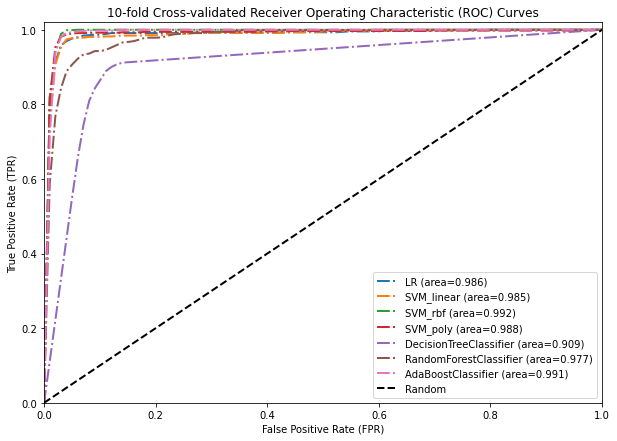

In [13]:
from tensorflow.keras import backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, auc
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, roc_auc_score
import pickle
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import recall_score
from sklearn.ensemble import VotingClassifier
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, auc, matthews_corrcoef, precision_recall_curve, average_precision_score
from imblearn.metrics import sensitivity_score, specificity_score
from scipy import interp
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

def auROCplot():
    ### auROC ###
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Random')
    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('10-fold Cross-validated Receiver Operating Characteristic (ROC) Curves')
    # plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')

    plt.savefig('cv_AuROC.png', dpi=100)
    plt.show()
    ### --- ###


    
def runAll(X, y):
    Names = []
    Classifiers = []
    estimators = {
             "LR": LogisticRegression(),
             "SVM_linear": svm.SVC(kernel='linear', gamma='scale', probability=True),
             "SVM_rbf": svm.SVC(kernel='rbf', gamma='scale', probability=True),
             "SVM_poly": svm.SVC(kernel='poly', gamma='scale', probability=True),
             #"GaussianNB": GaussianNB()
    #model = svm.SVC(kernel='linear', degree=3, gamma='scale')
    #model = svm.SVC(kernel='poly', degree=3, gamma='scale')
    #model = svm.SVC(kernel='rbf', degree=3, gamma='scale')
    #model = svm.SVC(kernel='sigmoid', degree=3, gamma='scale')
    "DecisionTreeClassifier": DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=2, min_samples_leaf=1),
    "RandomForestClassifier": RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=2, max_features='auto', min_impurity_split=None, min_samples_leaf=4, min_samples_split=10, n_estimators=300, oob_score=False, random_state=0, warm_start=False),
    "AdaBoostClassifier": AdaBoostClassifier(n_estimators=100, random_state=0)
    #model = GaussianNB()
    #model = BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)
    #model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=1, max_iter=300, learning_rate='constant', learning_rate_init=0.001)
    #model = MLPClassifier(random_state=1, max_iter=300)
    #model = RotationForestClassifier(n_estimators=100, random_state=47, verbose=4, n_jobs=-2)
              
}


    for key, value in estimators.items():
        Names.append(key)
        Classifiers.append(value)


    Results = []  # compare algorithms


    from sklearn.metrics import accuracy_score, \
        confusion_matrix, \
        roc_auc_score,\
        average_precision_score,\
        roc_curve, f1_score, recall_score, matthews_corrcoef, auc


    # Step 05 : Spliting with 10-FCV :
    from sklearn.model_selection import StratifiedKFold


    cv = StratifiedKFold(n_splits=10, shuffle=True)


    for classifier, name in zip(Classifiers, Names):


        accuray = []
        auROC = []
        avePrecision = []
        F1_Score = []
        AUC = []
        MCC = []
        Recall = []


        mean_TPR = 0.0
        mean_FPR = np.linspace(0, 1, 100)


        CM = np.array([
            [0, 0],
            [0, 0],
        ], dtype=int)


        print(classifier.__class__.__name__)


        model = classifier
        for (train_index, test_index) in cv.split(X, y):


            X_train = X[train_index]
            X_test = X[test_index]


            y_train = y[train_index]
            y_test = y[test_index]


            model.fit(X_train, y_train)




            # Calculate ROC Curve and Area the Curve
            y_proba = model.predict_proba(X_test)[:, 1]
            FPR, TPR, _ = roc_curve(y_test, y_proba)
            mean_TPR += np.interp(mean_FPR, FPR, TPR)
            mean_TPR[0] = 0.0
            roc_auc = auc(FPR, TPR)
            ##########################################
            # print(FPR)
            # print(TPR)
            ##########################################


            y_artificial = model.predict(X_test)


            auROC.append(roc_auc_score(y_test, y_proba))


            accuray.append(accuracy_score(y_pred=y_artificial, y_true=y_test))
            avePrecision.append(average_precision_score(y_test, y_proba)) # auPR
            F1_Score.append(f1_score(y_true=y_test, y_pred=y_artificial))
            MCC.append(matthews_corrcoef(y_true=y_test, y_pred=y_artificial))
            Recall.append(recall_score(y_true=y_test, y_pred=y_artificial))
            AUC.append(roc_auc)


            CM += confusion_matrix(y_pred=y_artificial, y_true=y_test)


        accuray = [_*100.0 for _ in accuray]
        Results.append(accuray)

        mean_TPR /= cv.get_n_splits(X, y)
        mean_TPR[-1] = 1.0
        mean_auc = auc(mean_FPR, mean_TPR)
        #plt.figure(figsize=(10,7))
        plt.rcParams["figure.figsize"] = (10,7)
        plt.plot(
            mean_FPR,
            mean_TPR,
            linestyle='dashdot',
            label='{} (area={:0.3f})'.format(name, mean_auc), lw=2.0), 
            

        print('Accuracy: {0:.4f} %'.format(np.mean(accuray)))
        # print('auROC: {0:.6f}'.format(np.mean(auROC)))
        print('auROC: {0:.6f}'.format(mean_auc))
        print('auPR: {0:.4f}'.format(np.mean(avePrecision))) # average_Precision
        print('F1-score: {0:.4f}'.format(np.mean(F1_Score)))
        print('MCC: {0:.4f}'.format(np.mean(MCC)))
        print('average_AUC:', np.mean(AUC))
        # tn, fp, fn, tp = CM.ravel()
        TN, FP, FN, TP = CM.ravel()
        print('Recall: {0:.4f}'.format( np.mean(Recall)) )
        print('AUC: {0:.4f}'.format( np.mean(AUC)) )
        print('Sensitivity (+): {0:.4f} %'.format( float( (TP) / (TP + FN) )*100.0 ))
        print('Specificity (-): {0:.4f} %'.format( float( (TN) / (TN + FP) )*100.0 ))
        print('Confusion Matrix:')
        print(CM)


        print('_______________________________________')


    ### auROC Curve ###
    auROCplot()
 
runAll(x_train, y_train)